In [174]:
# -*- coding: utf-8 -*-
"""
Created on Sat november 05 13:18:15 2016
@author: Sidon
"""
%matplotlib inline
import pandas as pd
import numpy as np
from collections import OrderedDict
from tabulate import tabulate, tabulate_formats
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%f'%x)

usecols = ['country','incomeperperson','alcconsumption','armedforcesrate','breastcancerper100th','co2emissions',
           'femaleemployrate','internetuserate','lifeexpectancy','polityscore', 'relectricperperson',
           'suicideper100th', 'employrate', 'urbanrate']


# Load from CSV
data0 = pd.read_csv('~/dev/coursera/gapminder.csv', skip_blank_lines=True,
                     usecols=usecols)


In [175]:
def to_num(list, data):
    for dt in list :
        data[dt] = pd.to_numeric(data[dt], 'errors=coerce')
    return data    
        

In [176]:

def interpret_clusters(n, train):
    
    chars = ['o', 'v', '*', 'p', 'h']
    colors = ['r', 'g', 'b','r','g']
    model=KMeans(n_clusters=n)
    model.fit(train)
    #clusassign=model.predict(train)
  
    
    # plot clusters
    pca_2 = PCA(2)
    
    plt.subplots(figsize=(12, 8))
    plot_columns = pca_2.fit_transform(train)
    
     
    #plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model.labels_, s=200)

    sc = plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model.labels_, s=200)
 
    plt.xlabel('Canonical variable 1')
    plt.ylabel('Canonical variable 2')
    plt.title('Scatterplot of Canonical Variables for '+str(n)+' Clusters')
    plt.show()
    return model

In [177]:
columns = ['country','income','alcohol','army','bcancer','co2','female-employ','net-rate','life', 'polity',
           'relectricperperson', 'suicideper100th', 'employ','urban']

cluster_cols = columns.copy()
for column in ['country', 'life']:
    cluster_cols.remove(column)
    
#cluster_cols = ['income','alcohol', 'net-rate' ]    

In [178]:
# Rename columns for clarity                                    
data0.columns = columns

# converting to numeric values and parsing (numeric invalids=NaN)
data0 = to_num( cluster_cols+['life'], data0 )

# Remove rows with nan values
data0 = data0.dropna(axis=0, how='any')

# Copy dataframe for preserve original
data1 = data0.copy()

In [179]:
# Subset clustering variables
cluster = data1[cluster_cols]
#print (cluster)

In [180]:
# standardize clustering variables to have mean=0 and sd=1
cluster_s=cluster.copy()

for c in cluster_s:
    cluster_s[c]=preprocessing.scale(cluster_s[c].astype('float64'))

#print(cluster_s)

In [181]:
# split data into train and test sets
clus_train, clus_test =  train_test_split(cluster_s, test_size=.3, random_state=123)


In [182]:
# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
range_clusters=range(1,9)
meandist=[]

for k in range_clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])


In [183]:
print (meandist)    

[3.1108099467242418, 2.6067405118778573, 2.3378498636470839, 2.1875343243904761, 2.0049697005947835, 1.9229146469088039, 1.8473593975658014, 1.7665778795883131]


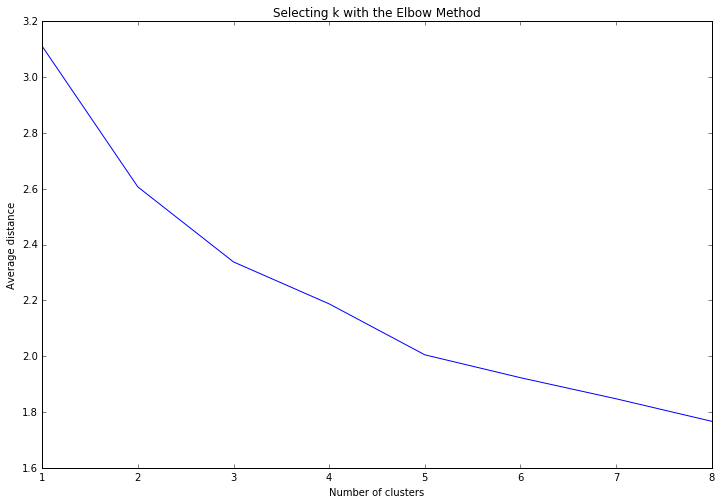

In [184]:
"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
plt.subplots(figsize=(12, 8))
plt.plot(range_clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

plt.show()


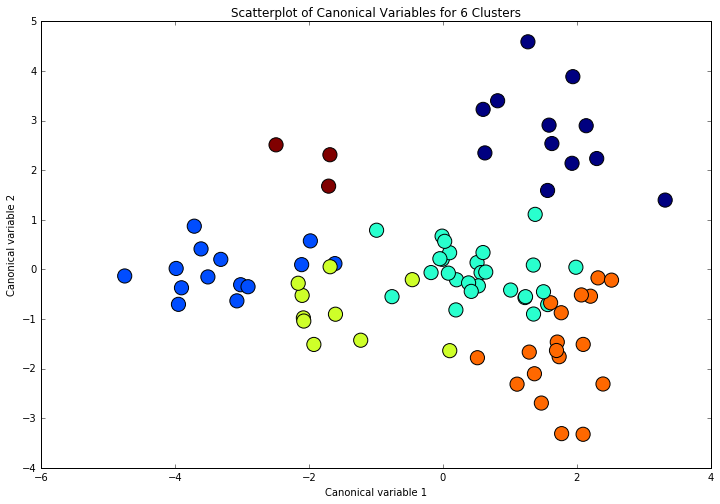

In [185]:
# Interpret 3 cluster solution
model = interpret_clusters(6, clus_train)

In [186]:
#model = models[2][0]

clus_train.reset_index(level=0, inplace=True)
cluslist=list(clus_train['index'])
labels=list(model.labels_)

newlist=dict(zip(cluslist, labels))
newclus=pd.DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']

In [187]:
newclus.reset_index(level=0, inplace=True)
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
merged_train.cluster.value_counts()

2    27
4    18
1    14
0    12
3    10
5     3
Name: cluster, dtype: int64

In [188]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
             index    income   alcohol      army   bcancer       co2  \
cluster                                                                
0       120.000000 -0.398503 -1.229453  1.465067 -0.642562 -0.163962   
1       104.500000  1.689797  0.720297 -0.457375  1.519534  0.282473   
2        92.370370 -0.492649 -0.123528 -0.390097 -0.384317 -0.147163   
3        89.800000 -0.229030  1.565672 -0.065280  0.352798 -0.146155   
4       130.555556 -0.695476 -0.635117 -0.441413 -0.816329 -0.070053   
5       140.000000  2.052627 -1.073743  1.874411  0.734091 -0.210512   

         female-employ  net-rate    polity  relectricperperson  \
cluster                                                          
0            -1.644191 -0.371289 -1.356611           -0.133186   
1             0.256264  1.325629  0.844124            0.781501   
2            -0.240065 -0.498376  0.261200           -0.435015   
3             0.209535  0.728993  0.187864           -0.

In [189]:
# validate clusters in training data by examining cluster differences in GPA using ANOVA
# first have to merge GPA with clustering variables and cluster assignment data 
gpa_data=data0['life']
# split GPA data into train and test sets
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1=pd.DataFrame(gpa_train)
gpa_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(gpa_train1, merged_train, on='index')
sub1 = merged_train_all[['life', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

gpamod = smf.ols(formula='life ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:                   life   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     14.04
Date:                Sat, 12 Nov 2016   Prob (F-statistic):           8.74e-10
Time:                        15:25:20   Log-Likelihood:                -276.36
No. Observations:                  84   AIC:                             564.7
Df Residuals:                      78   BIC:                             579.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          71.9571      1.946     

In [190]:
print ('means for life by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)


means for life by cluster
             life
cluster          
0       71.957083
1       80.385214
2       68.460148
3       73.466400
4       61.986389
5       80.371667


In [191]:
print ('standard deviations for life by cluster')
m2= sub1.groupby('cluster').std()
print (m2)


standard deviations for life by cluster
            life
cluster         
0       4.127489
1       1.921582
2       8.670045
3       3.937562
4       8.431088
5       1.750005


In [192]:
mc1 = multi.MultiComparison(sub1['life'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  0      1     8.4281   0.6807  16.1755   True 
  0      2    -3.4969  -10.3295  3.3356  False 
  0      3     1.5093   -6.923   9.9416  False 
  0      4    -9.9707  -17.3101 -2.6313   True 
  0      5     8.4146  -4.2976  21.1267  False 
  1      2    -11.9251 -18.411  -5.4392   True 
  1      3    -6.9188  -15.0727  1.2351  False 
  1      4    -18.3988 -25.4166 -11.3811  True 
  1      5    -0.0135  -12.5428 12.5157  False 
  2      3     5.0063   -2.284  12.2965  False 
  2      4    -6.4738  -12.4663 -0.4812   True 
  2      5    11.9115  -0.0736  23.8966  False 
  3      4     -11.48  -19.2473 -3.7128   True 
  3      5     6.9053  -6.0586  19.8692  False 
  4      5    18.3853   6.1042  30.6664   True 
-----------------------------------------------
